# Data

In [56]:
import os
import array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class DataHolder:
    def __init__(self, data_path = './korp_stats.bin'):
        self.load_data(data_path)
        
    def load_data(self, data_path):
        double_size = 8

        n_nums = int(os.path.getsize(data_path)/double_size)
        n_content = 5
        if n_nums % n_content != 0:
            print("Oops, something went wrong with the file size and contents.")
        n_entries = int(n_nums/n_content)
        F = open(data_path, 'rb')
        data = array.array('d')
        data.fromfile(F, n_nums)
        F.close()
        data = np.array(data)
        data = np.reshape(data, (n_entries, n_content))
        self.raw_data = data
        
        # NOTE: somehow there is ligand with index -1, shift all indices by one for convenience
        self.raw_data[:,1] += 1
        
        self._process_raw_data()
        
    def _process_raw_data(self):
        self.max_row = self.raw_data.max(axis=0)
        self.min_row = self.raw_data.min(axis=0)
        
        self.num_proteins = int(self.max_row[0]) + 1
        self.num_ligands = int(self.max_row[1]) + 1
        self.min_distance = self.min_row[2]
        self.max_distance = self.max_row[2]
        
    def describe(self):
        print('Dataset contains {} proteins x {} ligands, total {} points; distance range {:.2f}-{:.2f} Å'
            .format(
                self.num_proteins,
                self.num_ligands,
                len(self.raw_data),
                self.min_distance,
                self.max_distance))
        print('Min row: {}'.format(self.min_row))
        print('Max row: {}'.format(self.max_row))
        
    def get_points_for_pair(self, a, b):
        assert a < self.num_proteins
        assert b < self.num_ligands
        return self.raw_data[np.where((self.raw_data[:, 0] == a) & (self.raw_data[:, 1] == b))][:, 2:]

In [20]:
data = DataHolder()

In [21]:
data.get_points_for_pair(0, 0)

array([[16.6802361 ,  1.45493459,  5.06505856],
       [12.34081887,  2.44732327,  1.33198919],
       [14.17844983,  2.38767475,  2.52023497],
       ...,
       [17.16970868,  2.73020298,  0.76670437],
       [19.85207542,  1.95339094,  0.48944169],
       [19.82717776,  1.28358379,  0.97600928]])

In [22]:
data.describe()

Dataset contains 21 proteins x 40 ligands, total 47916041 points; distance range 2.02-20.00 Å
Min row: [0.00000000e+00 0.00000000e+00 2.01911113e+00 1.25772576e-04
 5.77119490e-08]
Max row: [20.         39.         20.          3.14115844  6.28318523]


# Density estimation

Implementation details:

1. Estimation in 3D space - no spherical prior
2. Gaussian kernel
3. 10000 random points subsample max to speed up computation

In [23]:
def spherical_to_cartesian(points):
    #u = theta / (2 * np.pi)
    #v = (np.cos(phi) + 1) / 2
    
    r = points[:,0]
    
    # 0 - pi
    phi = points[:,1]
    
    # 0 - 2pi
    theta = points[:,2]
    
    res = np.zeros(points.shape)
    res[:,0] = r * np.sin(phi) * np.cos(theta)
    res[:,1] = r * np.sin(phi) * np.sin(theta)
    res[:,2] = r * np.cos(phi)
    return res

In [24]:
def map_to_square(phi, theta):
    assert phi.max() <= np.pi + 1e-3
    assert phi.min() >= -1e-3
    
    u = theta / (2 * np.pi)
    v = (-np.cos(phi) + 1) / 2
    u[u < 0] += 1
    u[u > 1] -= 1
    v[v < 0] += 1
    v[v > 1] -= 1
    return u, v

def plot_for_distance_range(data, d_min, d_max):
    data_local = data[np.where(
        (data[:, 0] > d_min) & (data[:, 0] <= d_max))
    ][:, 1:]
    
    #print(data_local.shape[0])
    if data_local.shape[0] < 10:
        return
        
    u, v = map_to_square(data_local[:,0], data_local[:,1])

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.text(0.1, 0.85, '({},{}]'.format(d_min, d_max), color='fuchsia', fontsize=20)
    plt.scatter(u, v, s=1000.0 / len(u))
    
def plot_all_distance_ranges(data):
    plt.figure(figsize=(15, 15))
    for d in range(2, 20):
        plt.subplot(5, 4, 1 + d)
        plot_for_distance_range(data, d, d + 1)
    plt.show()
    
def plot_for_pair(a, b):
    plt.figure(figsize=(15, 15))
    sub_data = data[np.where(
            (data[:, 0] == a) &
            (data[:, 1] == b))
        ][:,:]
    print('Got', sub_data.shape[0], 'values of', data.shape[0], 'for pair', a, '-', b)
    for d in range(2, 20):
        plt.subplot(5, 4, 1 + d)
        plot_for_distance_range(sub_data, d, d + 1)
    plt.show()

In [25]:
def plot_density(density_grid, no_axis=False, description=None, fontsize=20):
    dg = density_grid.copy()
    dg = dg.T
    # first index is X, second index is Y
    # plot orientation is usual: (0, 0) at bottom left
    plt.imshow(dg, cmap='Greys', extent=[0, 2*np.pi, 0,np.pi], aspect=2, origin='lower')
    if description is not None:
        plt.text(0.1, np.pi*0.92, description, color='fuchsia', fontsize=fontsize)

In [26]:
xxx, yyy = np.meshgrid(np.linspace(0, 10, 5), np.linspace(0, 5, 5), indexing='ij')
print(xxx[0,0], xxx[0, 1], xxx[1, 0])
print(xxx)
print(xxx.ravel().reshape(xxx.shape))

0.0 0.0 2.5
[[ 0.   0.   0.   0.   0. ]
 [ 2.5  2.5  2.5  2.5  2.5]
 [ 5.   5.   5.   5.   5. ]
 [ 7.5  7.5  7.5  7.5  7.5]
 [10.  10.  10.  10.  10. ]]
[[ 0.   0.   0.   0.   0. ]
 [ 2.5  2.5  2.5  2.5  2.5]
 [ 5.   5.   5.   5.   5. ]
 [ 7.5  7.5  7.5  7.5  7.5]
 [10.  10.  10.  10.  10. ]]


In [159]:
from sklearn.neighbors import KernelDensity

class DensityEstimate:
    def __init__(self, spherical_points, bandwidth=0.5, description=None):
        self.description = description
        self.spherical_points = spherical_points
        self.kde = KernelDensity(
            bandwidth=bandwidth, metric='euclidean', kernel='gaussian', algorithm='auto', rtol=0.1)
        
        max_points_for_fit = 10000
        points = spherical_to_cartesian(spherical_points)
        np.random.seed(42)
        np.random.shuffle(points)
        points = points[:max_points_for_fit,:]
        
        self.kde.fit(points)
        
    def get_density_grid_for_distance(self, r):
        #y_linspace = np.linspace(0, np.pi, 100)
        y_linspace = np.arccos(np.linspace(1, -1, 100))

        X, Y = np.meshgrid(np.linspace(0, 2 * np.pi, 100), y_linspace, indexing='ij')
        
        #print('zero-zero (2pi, pi)', X[0, 0], Y[0, 0])
        
        probe_points = spherical_to_cartesian(np.hstack(
            [np.ones((X.size, 1)) * r, Y.ravel().reshape(X.size, 1), X.ravel().reshape(Y.size, 1)]))
        prob = np.exp(self.kde.score_samples(probe_points))
        
        return prob.reshape(X.shape)
        
    def plot_density_for_distance(self, r, fontsize=20, no_axis=False):
        plot_density(self.get_density_grid_for_distance(r),
                     no_axis=no_axis, description=self.description, fontsize=fontsize)
        plt.text(0.1, np.pi*0.82, 'r={}Å'.format(r), color='fuchsia', fontsize=fontsize)
        
        if no_axis:
            plt.gca().set_yticklabels([])
            plt.gca().set_xticklabels([])
   
    def plot_point_cloud_for_range(self, d_min, d_max):
        plot_for_distance_range(self.spherical_points, d_min, d_max)
        
    def plot_point_cloud(self, r):
        self.plot_point_cloud_for_range(r - 0.5, r + 0.5)
        
    def comparative_plot(self, r):
        plt.figure(figsize=(14, 7))
        plt.subplot(1, 2, 1)
        self.plot_density_for_distance(r)
        plt.subplot(1, 2, 2)
        self.plot_point_cloud(r)
        plt.show()


In [160]:
def get_density_estimate_for_pair(a, b, bandwidth=0.5):
    spherical_points = data.get_points_for_pair(a, b)
    return DensityEstimate(spherical_points, bandwidth=bandwidth,
                           description=('{} - {} bw {}'.format(a, b, bandwidth)))

# p.d.f. maximums

In [29]:
density = get_density_estimate_for_pair(0, 5)

In [30]:
pdf = density.get_density_grid_for_distance(5)

In [259]:
def local_extremums(pdf):
    return 1 + np.argwhere(
        (pdf[1:-1,1:-1] > pdf[2:,1:-1])
        & (pdf[1:-1,1:-1] > pdf[0:-2,1:-1])
        & (pdf[1:-1,1:-1] > pdf[1:-1:,2:])
        & (pdf[1:-1,1:-1] > pdf[1:-1:,0:-2])
        & (pdf[1:-1,1:-1] > pdf.mean(axis=0).mean(axis=0) * 2)
    )

def kernel_extremums(pdf, kernel_size=10, min_ratio_to_max_pdf=0.2, min_pdf=0):
    # kernel size
    ok = None
    
    # small noise to avoid multi-maximums
    pdf = pdf + np.random.randn(*pdf.shape) * pdf.min() * 0.1
    
    def convolution(matrix):
        res = matrix
        for i in range(-1, 2):
            for j in range(-1, 2):
                if i == 0 and j == 0:
                    continue
                res = np.maximum(res, np.roll(matrix, (i, j), axis=(0, 1)))
        return res
    
    assert kernel_size >= 1
    conv_res = convolution(pdf)
    for i in range(kernel_size - 1):
        conv_res = convolution(conv_res)
    #print('conv res', conv_res)
    return np.argwhere((pdf == conv_res) & (pdf > max(min_ratio_to_max_pdf * pdf.max(), min_pdf)))

extremums = kernel_extremums(pdf)

In [260]:
a = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])
print(np.roll(a, (1, 1), axis=(0, 1)))
print(kernel_extremums(a))

[[16 13 14 15]
 [ 4  1  2  3]
 [ 8  5  6  7]
 [12  9 10 11]]
[[3 3]]


In [261]:
print(len(extremums))

4


In [244]:
print(extremums.shape)

(4, 2)


In [217]:
print('Min: {}'.format(pdf.min()))
print('Max: {}'.format(pdf.max()))
print(np.argwhere(pdf == pdf.max()))

Min: 1.2310406262485848e-09
Max: 0.0001710753951985962
[[36 96]]


In [218]:
density = get_density_estimate_for_pair(0, 5, 0.75)
pdf = density.get_density_grid_for_distance(4)

In [219]:
extremums = kernel_extremums(pdf)
print('Found {} extremums, max pdf {}'.format(len(extremums), pdf.max()))

for extr in extremums:
    print('extr {} {} value {}'.format(extr[0], extr[1], pdf[extr[0], extr[1]]))

Found 9 extremums, max pdf 0.0001710753951985962
extr 4 82 value 0.0001222731858339191
extr 4 99 value 8.572383874166676e-05
extr 21 41 value 1.80706593973455e-05
extr 26 21 value 2.7043560290088124e-05
extr 36 96 value 0.0001710753951985962
extr 66 32 value 3.375073470886299e-05
extr 76 71 value 1.952572829010878e-05
extr 84 36 value 2.786343984011727e-05
extr 88 99 value 8.572383874165823e-05


In [313]:
def plot_for_bandwidth(a, b, bandwidth, kernel_size=20, min_ratio_to_max_pdf=0.2):
    density = get_density_estimate_for_pair(a, b, bandwidth)
    
    r_range = list(range(5, 21)) 
    
    pdfs = []
    
    total_max = 0
    for r in r_range:
        pdfs.append(density.get_density_grid_for_distance(r))
        pdf = pdfs[-1]
        #print('for r {} min {} max {}'.format(r, pdf.min(), pdf.max()))
        total_max = max(total_max, pdf.max())
        
    num_extremums = []
    
    for index, r in enumerate(r_range):
        pdf = pdfs[index]
        
        if index % 2 == 0:
            if index != 0:
                plt.show()
            plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, index % 2 + 1)
        extremums = kernel_extremums(pdf, kernel_size=kernel_size, min_ratio_to_max_pdf=0, min_pdf=total_max * 0.2)
        #print('for {} found {} extremums, max pdf {}'.format(r, len(extremums), pdf.max()))
        num_extremums.append(len(extremums))
        
        #for extr in extremums:
        #    print('extr {} {} value {}'.format(extr[0], extr[1], pdf[extr[0], extr[1]]))
        
        #pdf_c = pdf.copy()
        #pdf_c[20, 20] = 10
        #pdf[0, 99] = 100
        pdf[0, 0] = total_max
        plot_density(pdf)
        plt.text(0.1, np.pi*0.05, '{} - {}, r={}Å, {} ex'.format(a, b, r, len(extremums)), color='fuchsia', fontsize=10)
        plt.scatter((extremums[:,0] + 0.5) / pdf.shape[0] * (2 * np.pi),
                    (extremums[:,1] + 0.5) / pdf.shape[1] * np.pi, s=8.0, color='red')
        plt.xlim(0, 2*np.pi)
        plt.ylim(0, np.pi)

        #plt.scatter([0], [0], s=100.0, color='green')
        #plt.scatter([np.pi / 4], [0], s=100.0, color='green')
        
    plt.show()
    plt.figure(figsize=(10,5))
    plt.plot(r_range, num_extremums)
    plt.xlabel('r')
    plt.ylabel('num extremums')
    plt.grid()
    plt.show()
    
    return list(zip(r_range, pdfs))

# Extremums for 0 - 5 pair

### gaussian kernel width = 1.0

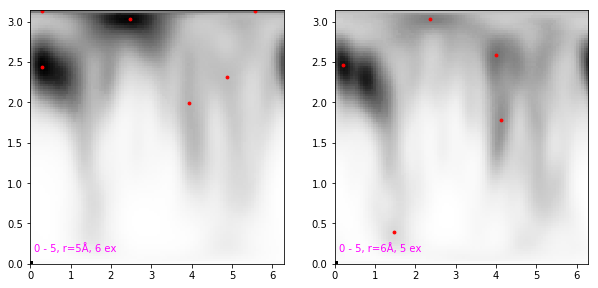

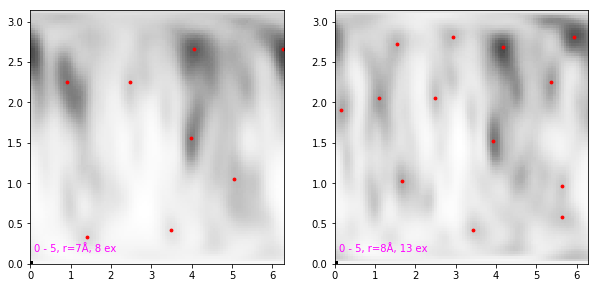

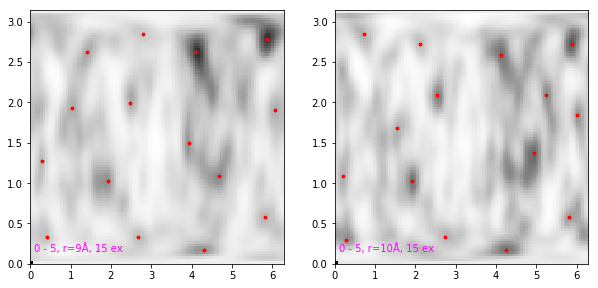

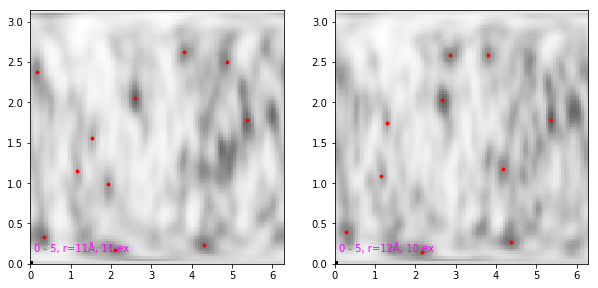

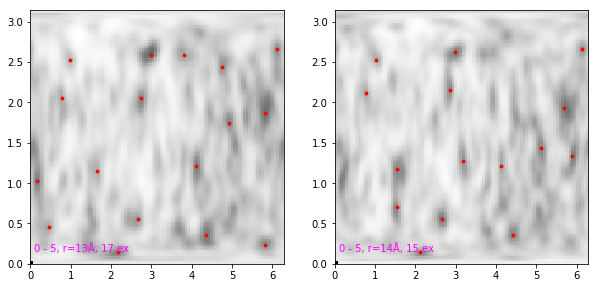

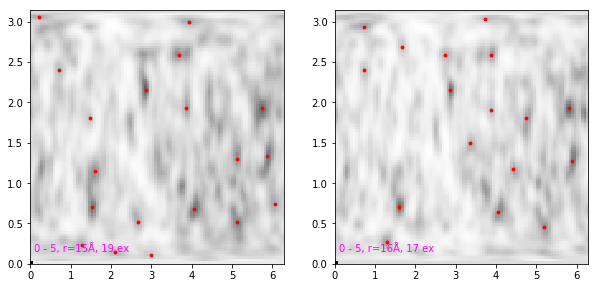

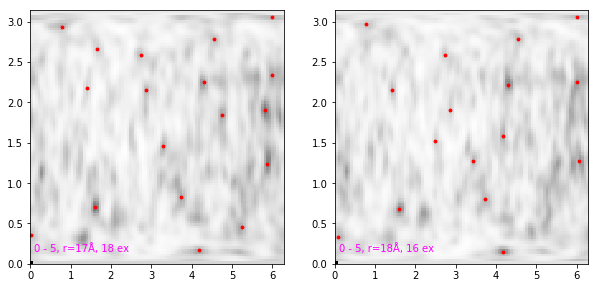

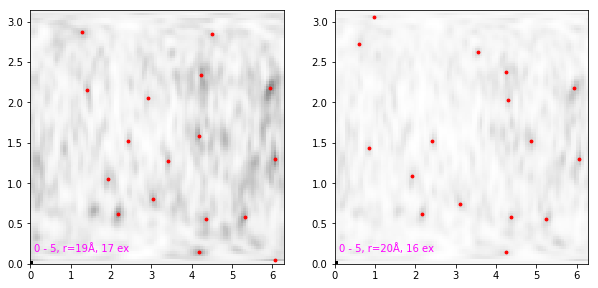

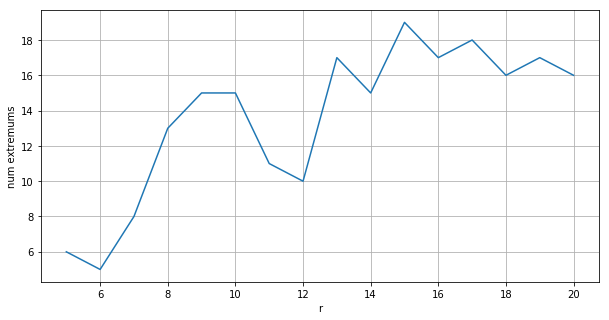

In [314]:
pdf_array = plot_for_bandwidth(0, 5, 1.0, 10, 0.5)

In [386]:
def plot_r_and_angle(pdf_array, axis, max_v, x_label):
    data = []
    rs = []
    for r, pdf in pdf_array:
        data.append(pdf.sum(axis=axis))
        rs.append(r)
    data = np.array(data)
    print(data.shape)
    plt.figure(figsize=(10, 10))
    plt.yticks(rs)
    plt.ylabel('r')
    plt.xlabel(x_label)
    plt.imshow(data, cmap='Greys', extent=[0, max_v, rs[0], rs[-1]], origin='lower', aspect=max_v/10)
    plt.show()
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection="3d")
    
    x = rs
    y = np.linspace(0, max_v, pdf.shape[0])

    X, Y = np.meshgrid(x, y)
    
    print(X.shape)
    print(data.shape)
    
    ax.plot_wireframe(X, Y, data.T, color='green')
    ax.set_xlabel('R')
    ax.set_ylabel(x_label)
    ax.set_zlabel('p.d.f. sum')

    plt.show()

# phi

(16, 100)


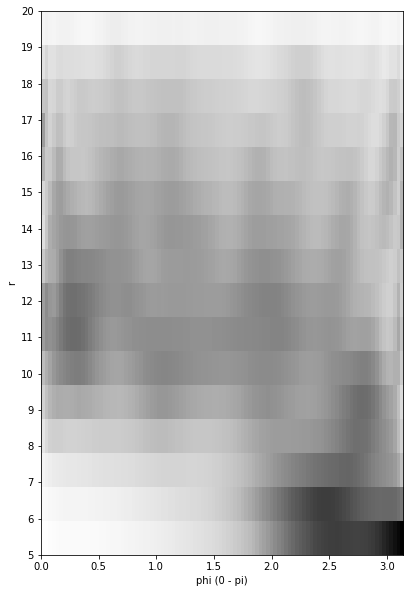

(100, 16)
(16, 100)


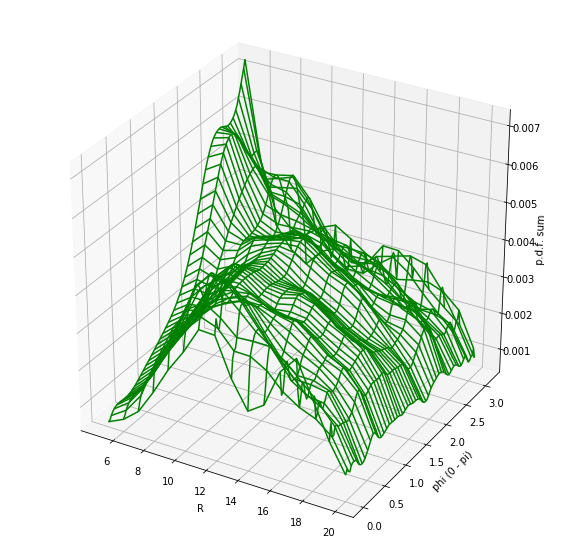

In [388]:
plot_r_and_angle(pdf_array, axis=0, max_v=np.pi, x_label='phi (0 - pi)')

# theta

(16, 100)


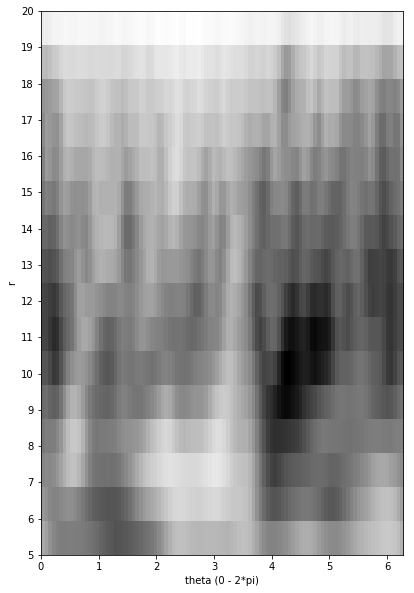

(100, 16)
(16, 100)


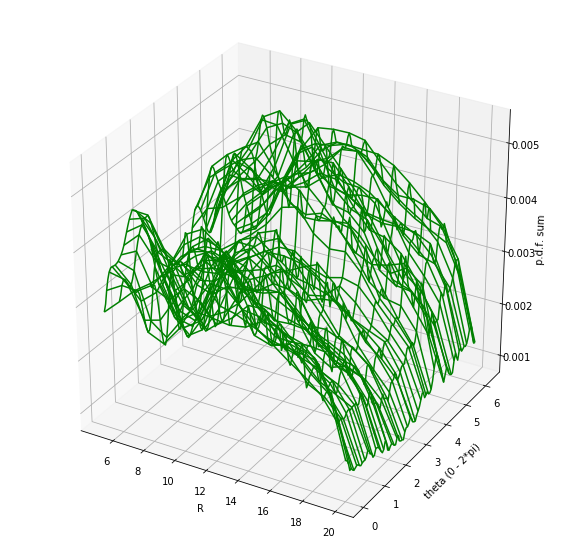

In [389]:
plot_r_and_angle(pdf_array, axis=1, max_v=2*np.pi, x_label = 'theta (0 - 2*pi)')

### gaussian kernel width = 2.0

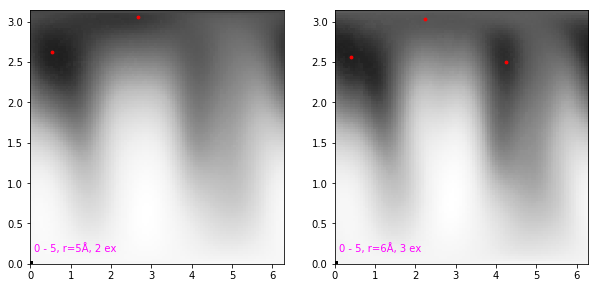

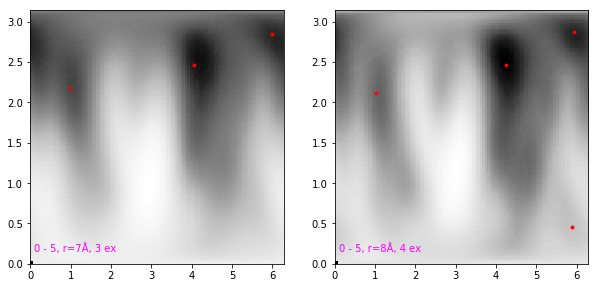

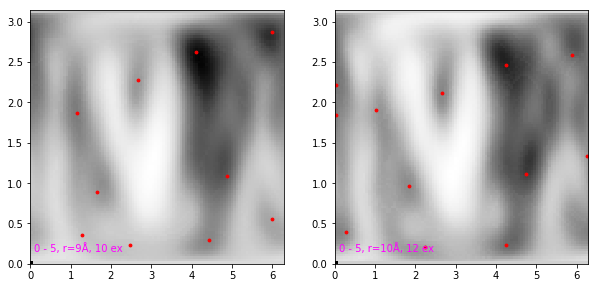

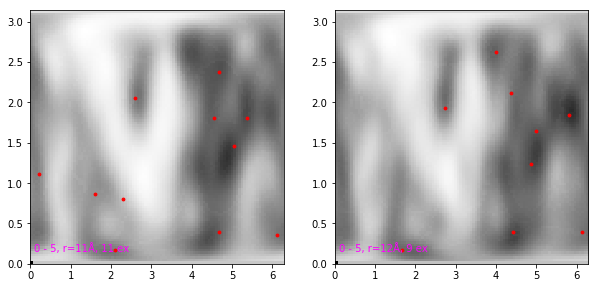

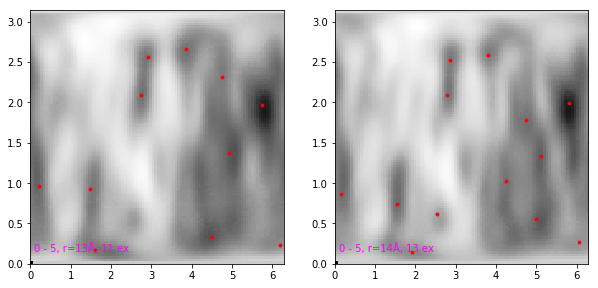

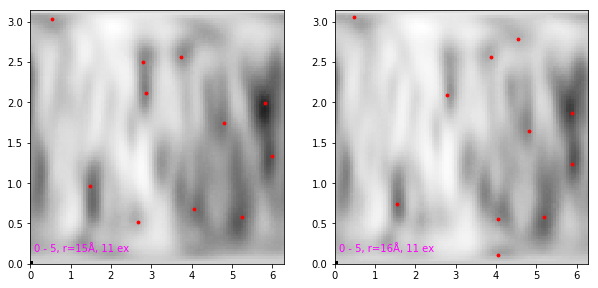

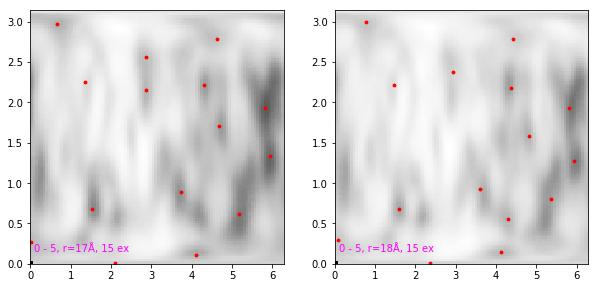

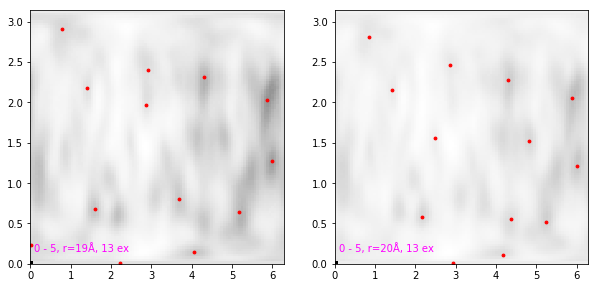

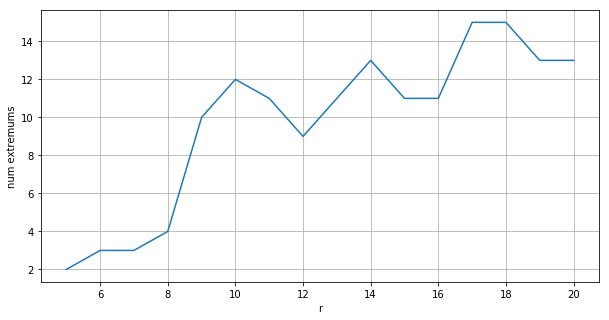

In [304]:
plot_for_bandwidth(0, 5, 2.0, 10, 0.5)

# Pair 0 - 0

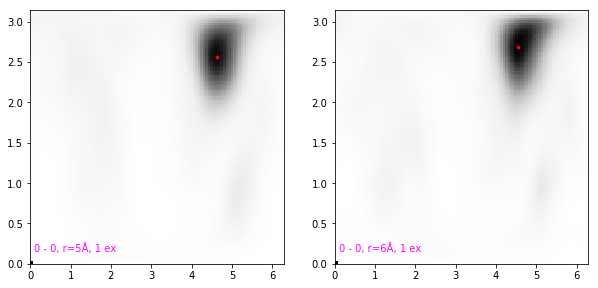

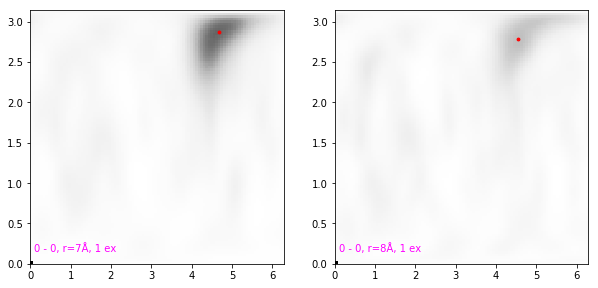

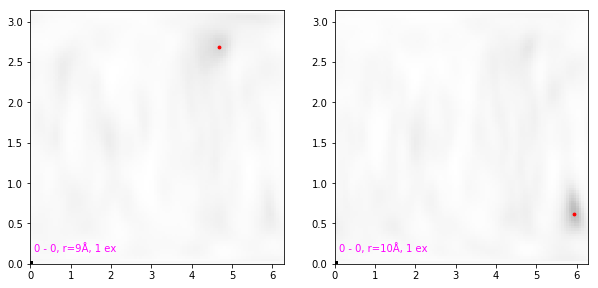

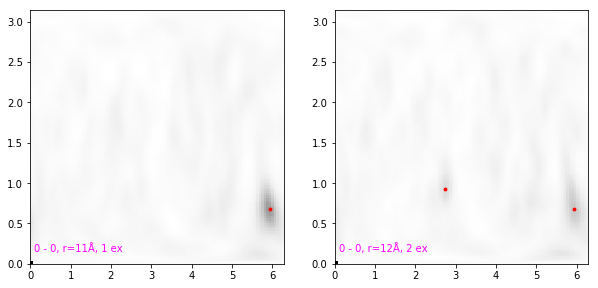

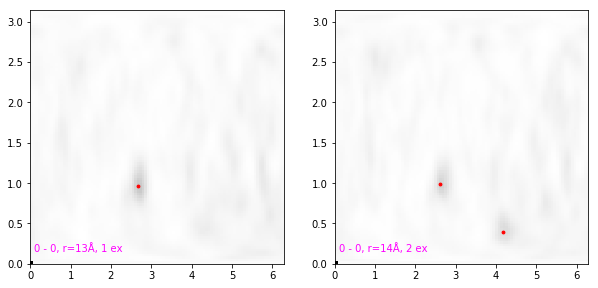

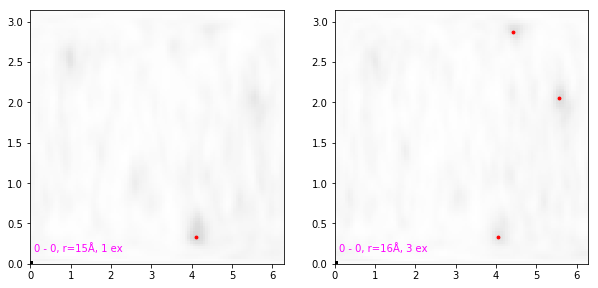

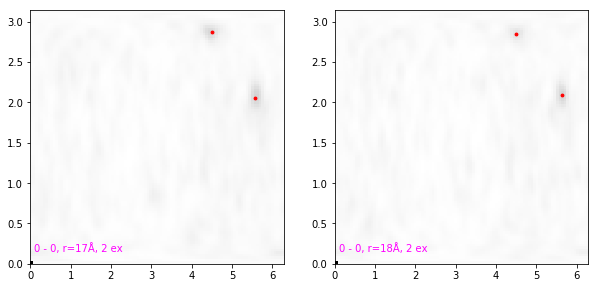

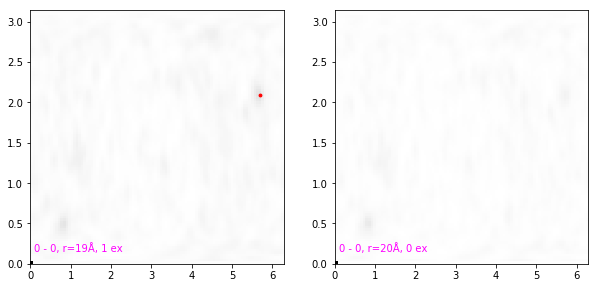

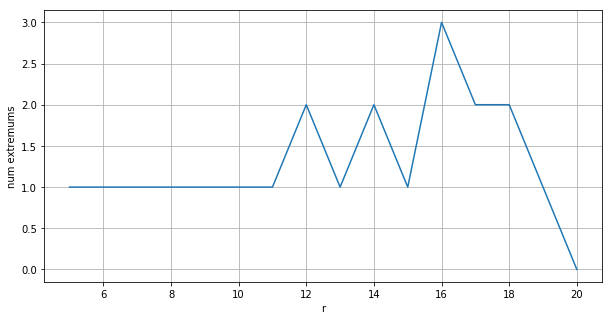

In [390]:
pdf_array = plot_for_bandwidth(0, 0, 1.0, 10, 0.5)

(16, 100)


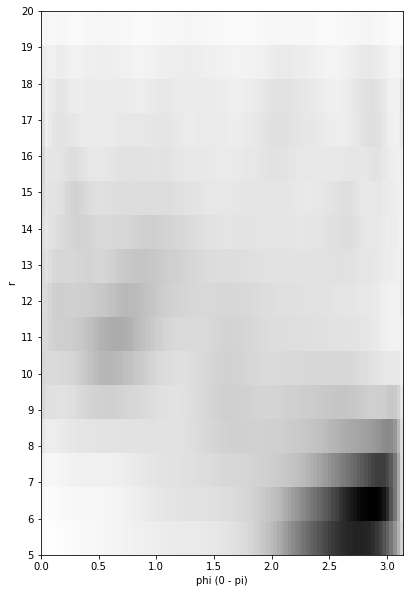

(100, 16)
(16, 100)


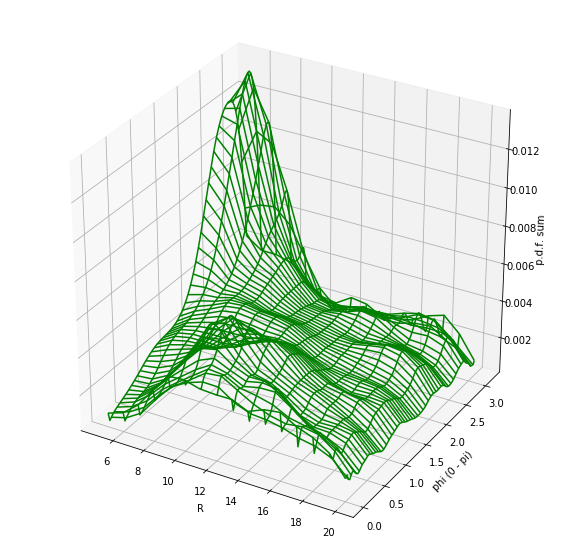

(16, 100)


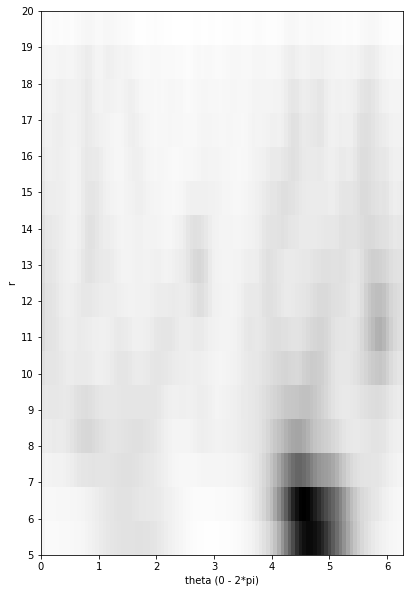

(100, 16)
(16, 100)


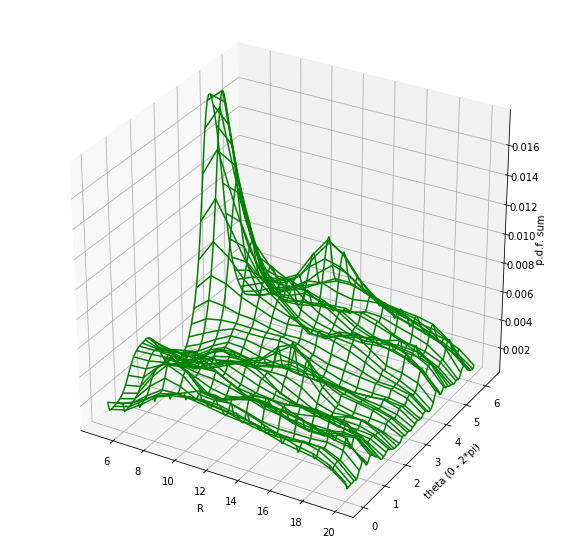

In [391]:
plot_r_and_angle(pdf_array, axis=0, max_v=np.pi, x_label='phi (0 - pi)')
plot_r_and_angle(pdf_array, axis=1, max_v=2*np.pi, x_label = 'theta (0 - 2*pi)')

# Pair 0 - 1

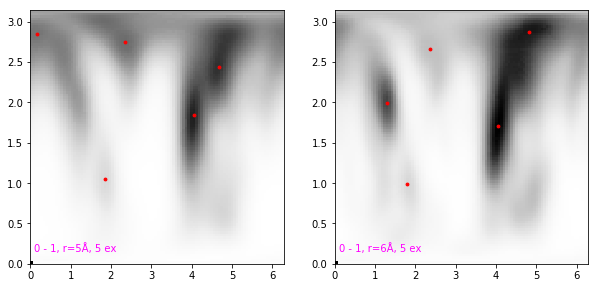

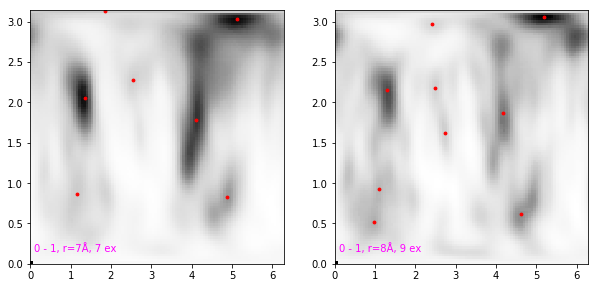

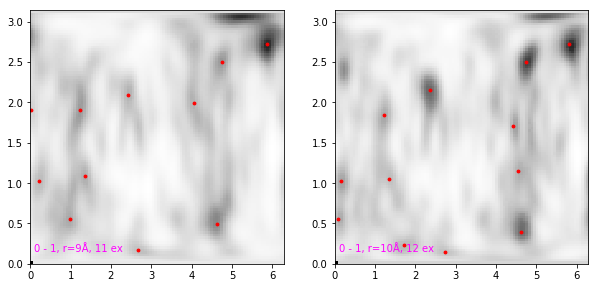

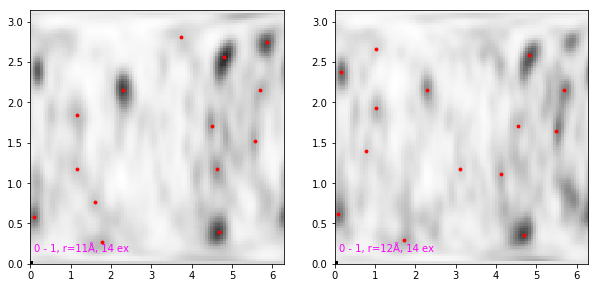

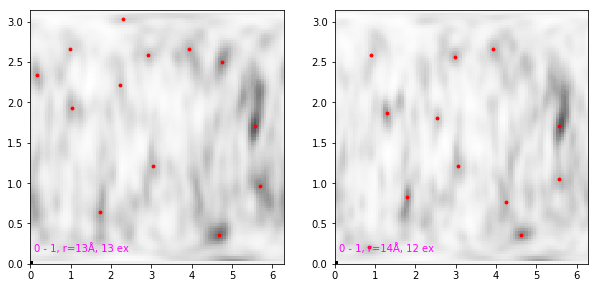

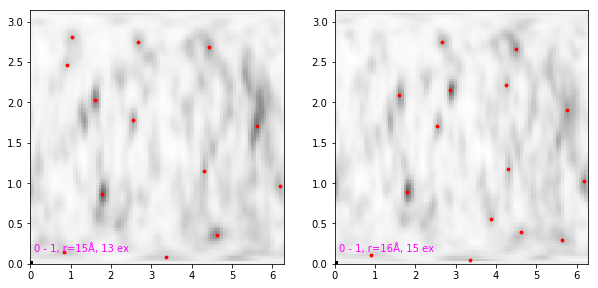

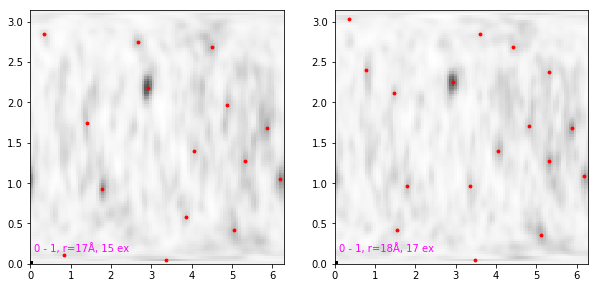

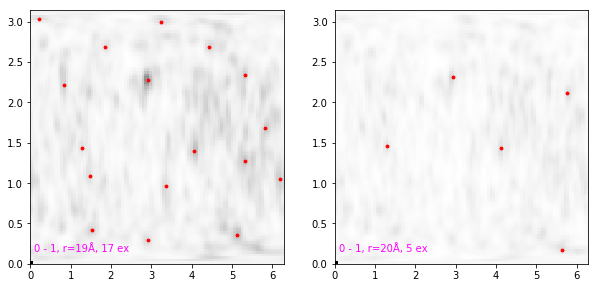

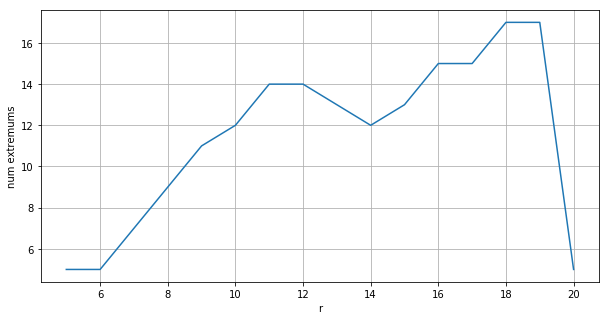

In [392]:
pdf_array = plot_for_bandwidth(0, 1, 1.0, 10, 0.5)

(16, 100)


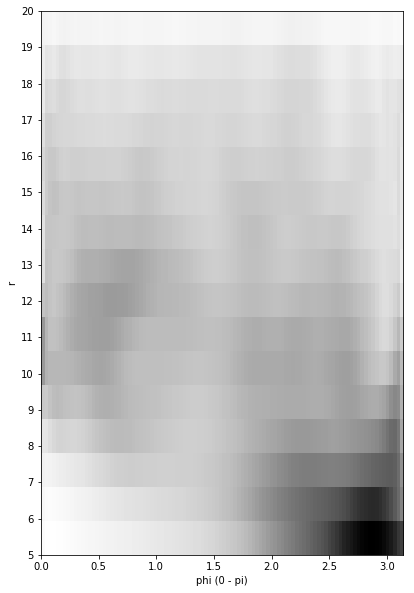

(100, 16)
(16, 100)


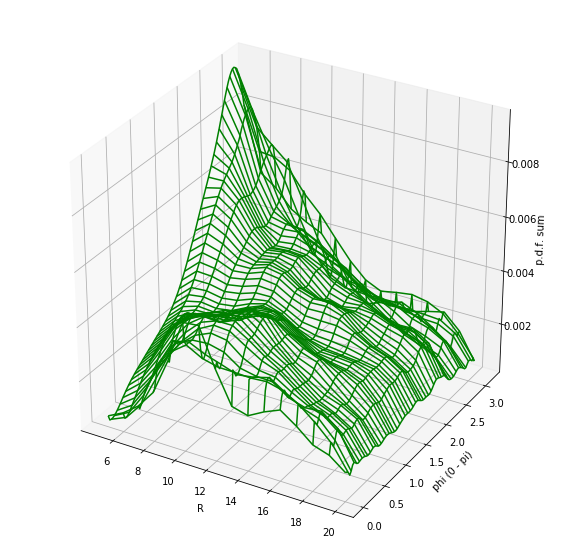

(16, 100)


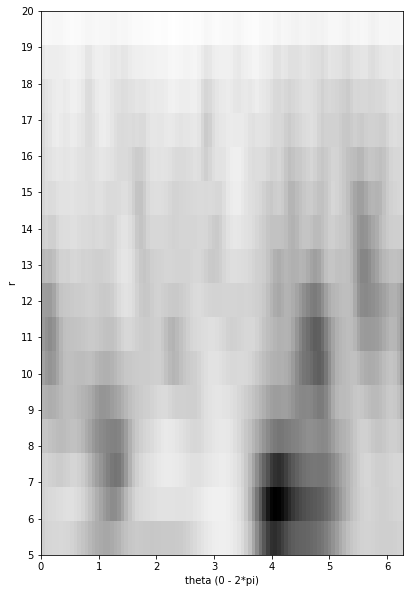

(100, 16)
(16, 100)


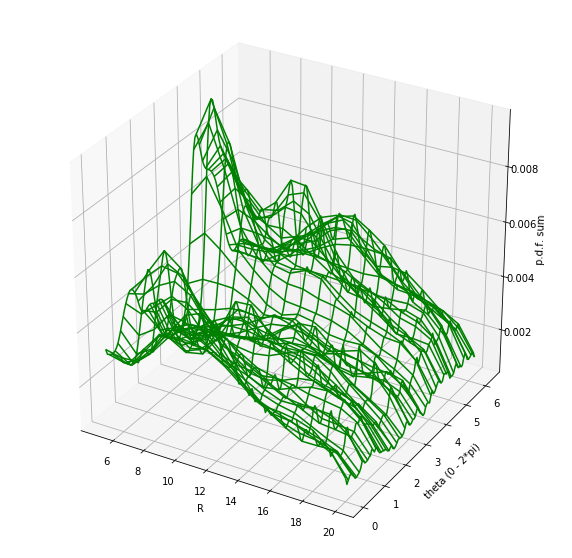

In [393]:
plot_r_and_angle(pdf_array, axis=0, max_v=np.pi, x_label='phi (0 - pi)')
plot_r_and_angle(pdf_array, axis=1, max_v=2*np.pi, x_label = 'theta (0 - 2*pi)')

# All in one plots (not so informative)

In [307]:
def get_extremums_3d(bandwidth):
    density = get_density_estimate_for_pair(0, 5, bandwidth)
    
    extremums_for_scatter = []
    extremums_cartesian = []
    
    for r in np.arange(5, 20, 1.0):
        pdf = density.get_density_grid_for_distance(r)
        extremums = kernel_extremums(pdf, kernel_size=20, min_ratio_to_max_pdf=0.4)
        print('for {} found {} extremums, max pdf {}'.format(r, len(extremums), pdf.max()))
        
        pdf_max = pdf.max()
        extr_strength = []
        for extr in extremums:
            extr_strength.append(pdf[extr[0], extr[1]] / pdf_max)
        extr_strength = np.array(extr_strength)
        
        #for extr in extremums:
        #    print('extr {} {} value {}'.format(extr[0], extr[1], pdf[extr[0], extr[1]]))
        #break
        
        extremums_for_scatter.append((
            r,
            (extremums[:,0] + 0.5) / pdf.shape[0] * (2 * np.pi),
            (extremums[:,1] + 0.5) / pdf.shape[1] * np.pi,
            extr_strength))
        
        shape = (len(extremums),1)
        cartesian = spherical_to_cartesian(np.hstack(
            [np.ones(shape) * r,
             extremums[:,1].reshape(shape), extremums[:,0].reshape(shape)]))
        
        extremums_cartesian = extremums_cartesian + list(cartesian)
    
    return np.array(extremums_cartesian), extremums_for_scatter

extremums_cartesian, extremums_for_scatter = get_extremums_3d(1.0)

for 5.0 found 2 extremums, max pdf 0.000124091885325554
for 6.0 found 2 extremums, max pdf 0.00011640697316699912
for 7.0 found 3 extremums, max pdf 9.48881471754304e-05
for 8.0 found 4 extremums, max pdf 9.63200955510198e-05
for 9.0 found 5 extremums, max pdf 0.00010615775627655556
for 10.0 found 6 extremums, max pdf 9.134294523871905e-05
for 11.0 found 6 extremums, max pdf 8.836460169098382e-05
for 12.0 found 5 extremums, max pdf 8.985925764700088e-05
for 13.0 found 6 extremums, max pdf 8.64062556229027e-05
for 14.0 found 5 extremums, max pdf 7.896835351956965e-05
for 15.0 found 4 extremums, max pdf 8.541208668476913e-05
for 16.0 found 4 extremums, max pdf 8.536875287257376e-05
for 17.0 found 6 extremums, max pdf 7.81968725666006e-05
for 18.0 found 6 extremums, max pdf 7.256291419231457e-05
for 19.0 found 7 extremums, max pdf 6.95708802492573e-05


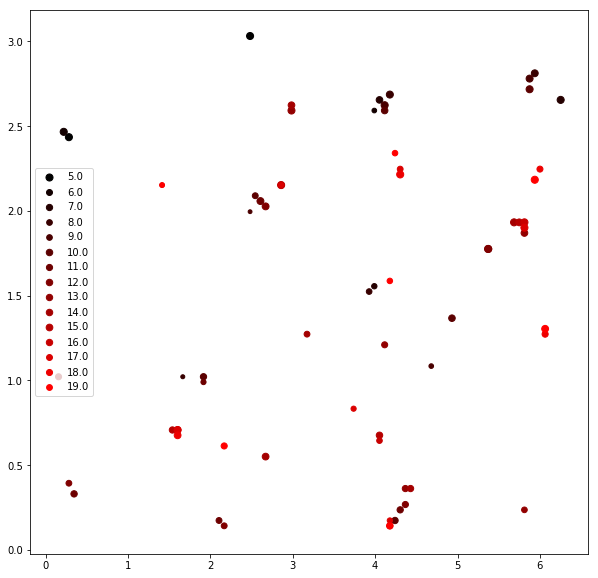

In [308]:
plt.figure(figsize=(10,10))
for r, extremums_x, extremums_y, extremums_s in extremums_for_scatter:
    all_r = np.array(list(row[0] for row in extremums_for_scatter))
    color = (r - all_r.min()) / (all_r.max() - all_r.min())
    plt.scatter(extremums_x, extremums_y,label=str(r), s=50.0 * extremums_s ** 2, c=np.array([[color, 0, 0]]))
plt.legend()
plt.show()

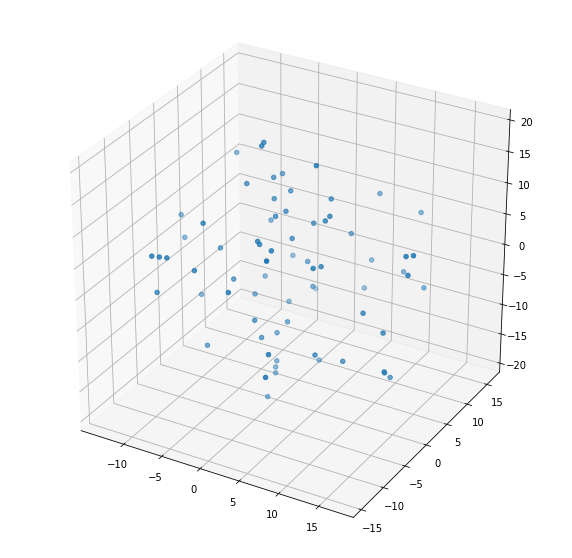

In [309]:
from mpl_toolkits import mplot3d
plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.scatter3D(extremums_cartesian[:,0], extremums_cartesian[:,1], extremums_cartesian[:,2])